Analyze Times series:

 Plot time series (give visual feedback)

 Caculate and plot ACF (give visual feedback)

 Check, if the time series is stationarity (using Augmented Dickey-Fuller (ADF) test)

 If there is a trend - remove it from the Time Series

 Check seasonality (visually and using ACF)

 Run automatic ARIMA model determination. Find the best model, give summary and display the results (existing time range + future)

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sma
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [6]:
pip install fsspec

Note: you may need to restart the kernel to use updated packages.Collecting fsspec
                                              0.0/163.8 kB ? eta -:--:--
     ---------------------                   92.2/163.8 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 163.8/163.8 kB 2.0 MB/s eta 0:00:00




[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
df = pd.read_csv('c://Users/Kristine/Desktop/DataSets/AirPassengers.csv', index_col=0, parse_dates=['Month'])

Exploring Data

In [8]:
df.shape

(144, 1)

In [9]:
df.isnull().sum()

#Passengers    0
dtype: int64

In [10]:
df.describe().T.apply(lambda s:s .apply('{0:.2f}'.format))  #transpose table and formating to two decimal

,count,mean,std,min,25%,50%,75%,max
#Passengers,144.00,280.30,119.97,104.00,180.00,265.50,360.50,622.00


In [11]:
df.head(3)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132


In [12]:
df.dtypes

#Passengers    int64
dtype: object

Plotting the Data

Text(0.5, 1.0, 'Air Passengers')

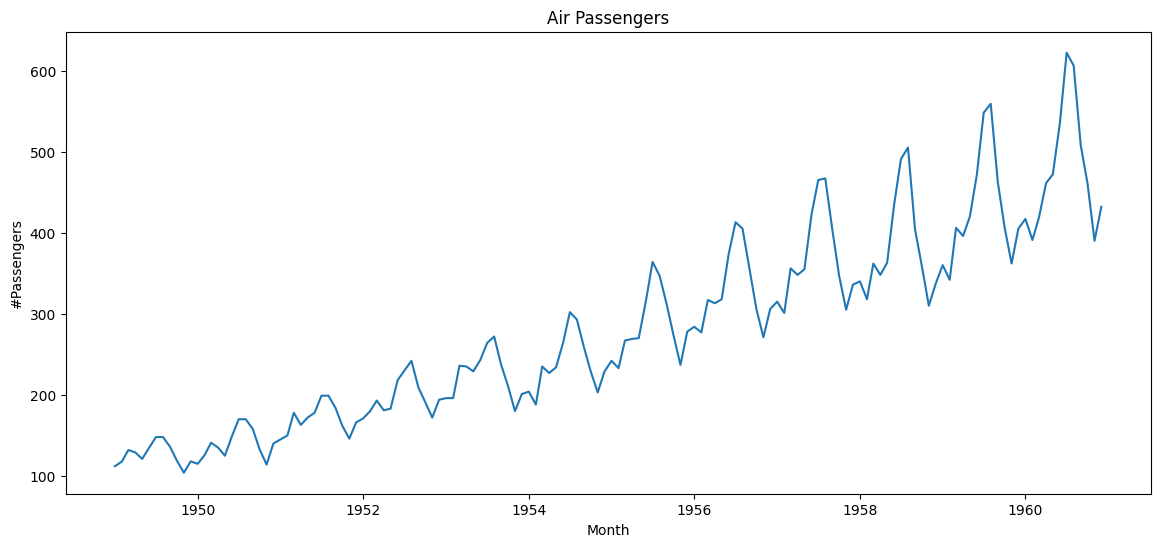

In [13]:
plt.figure(figsize=(14,6))
sns.lineplot(x='Month', y='#Passengers', data=df)
plt.title("Air Passengers")

The plot above shows a trend of increase in number of passengers as well it seems like data has seasonality. 

## AUTOCORRELATION FUNCTION (ACF)

In [14]:
df_acf = df.to_numpy().T[0]

<Figure size 2000x700 with 0 Axes>

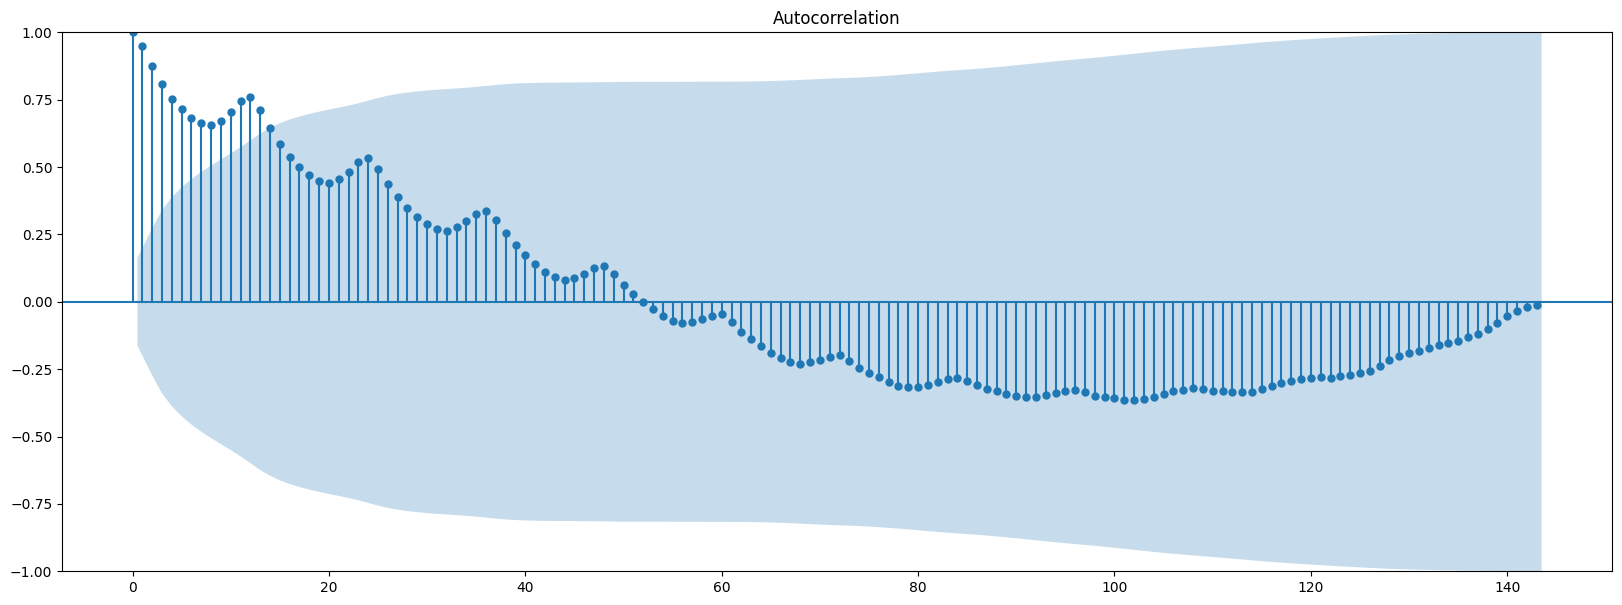

In [15]:
plt.rc('figure', figsize=(20,7))
plt.figure(figsize=(20,7))
plot_acf(df_acf, lags=143)
plt.show()

Horizontal cone pictures the confidence level, which by default is set to 95%.

In this case, it means that with 95% probability first 14 months have certain impact on values (as they are outside the cone). 

The 15th bar has a height of 0.63. This means that curret current data will impact data in 15 month by 63%.

There is significant increase in 13th index bar and this suggest a cycly of length 12 (12 months). And it repeats in every 12th index.

In this case ACF function drops dowm below zero approximetly on 52 index. 

A negative autocorrelation implies that if a past value is above the average, the newer more likely to be below the average.

Let's say if today will be observed the number of passengers higher than average we might say
that with 30% probability in 100 months we would observe less passengers than on average.


## Augmented Dickey-Fuller (ADF) test

In [16]:
adftest = adfuller(df['#Passengers'],autolag='AIC')
dfoutput=pd.Series(adftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in adftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Test Statistic                   0.815369
p-value                          0.991880
#lags used                      13.000000
number of observations used    130.000000
critical value (1%)             -3.481682
critical value (5%)             -2.884042
critical value (10%)            -2.578770
dtype: float64


The result of the dickey-fuller test consists of values like test statistics, p-value critical values, etc. 

For our data the test statistic value (0.81)) is not less than the critical values (-3.48 , -2.88 , -2.57) at different percentage . 

In this case, we cannot reject our null hypothesis and conclude that our data is not stationary. 

### Time Series decomposition using statsmodels

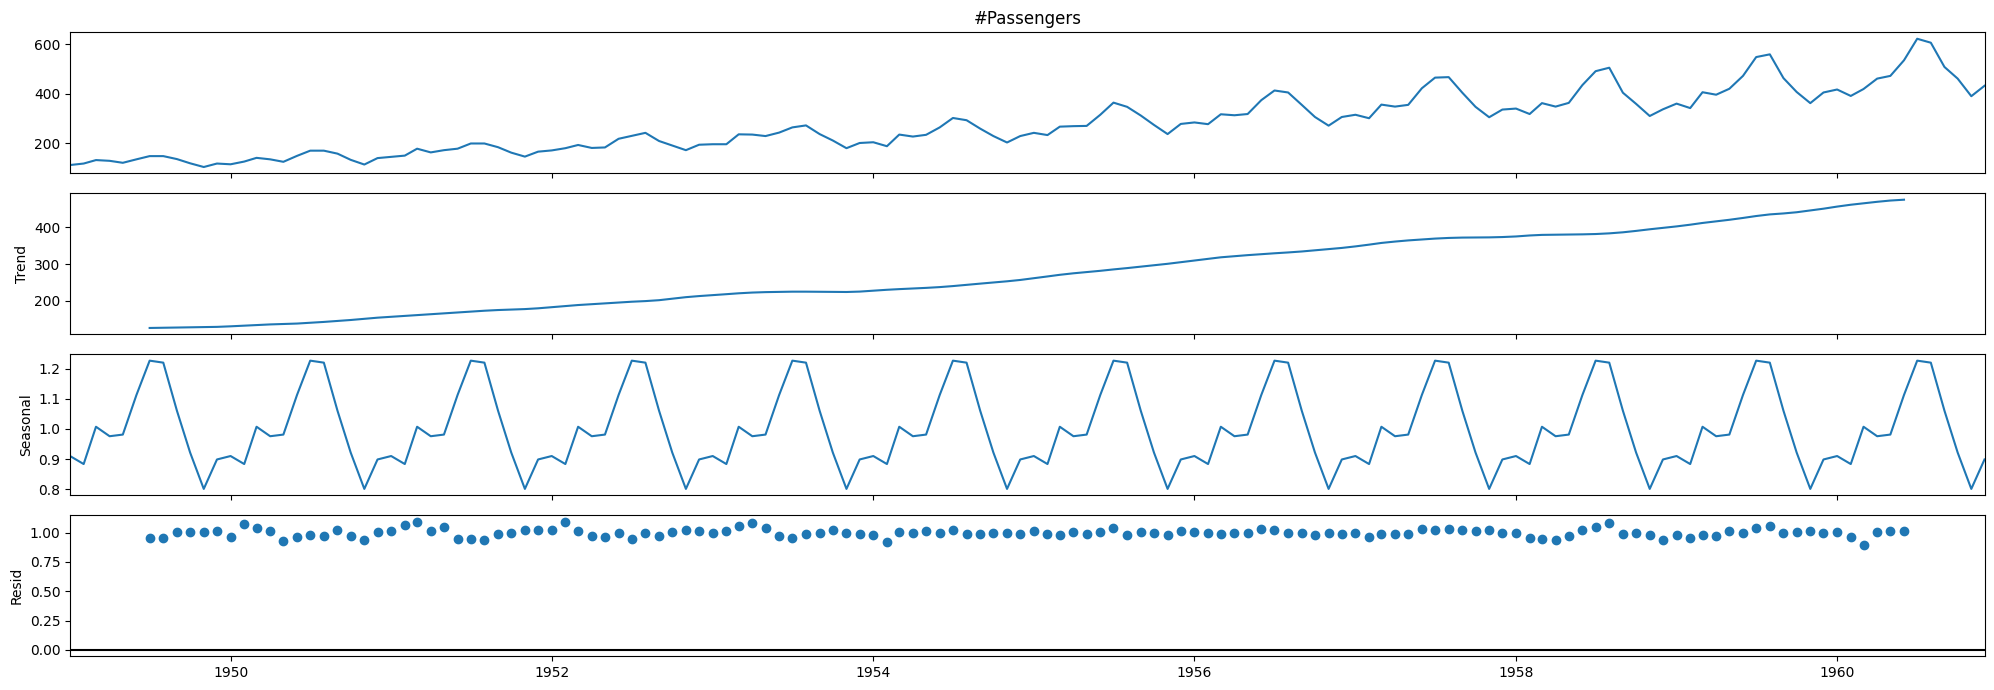

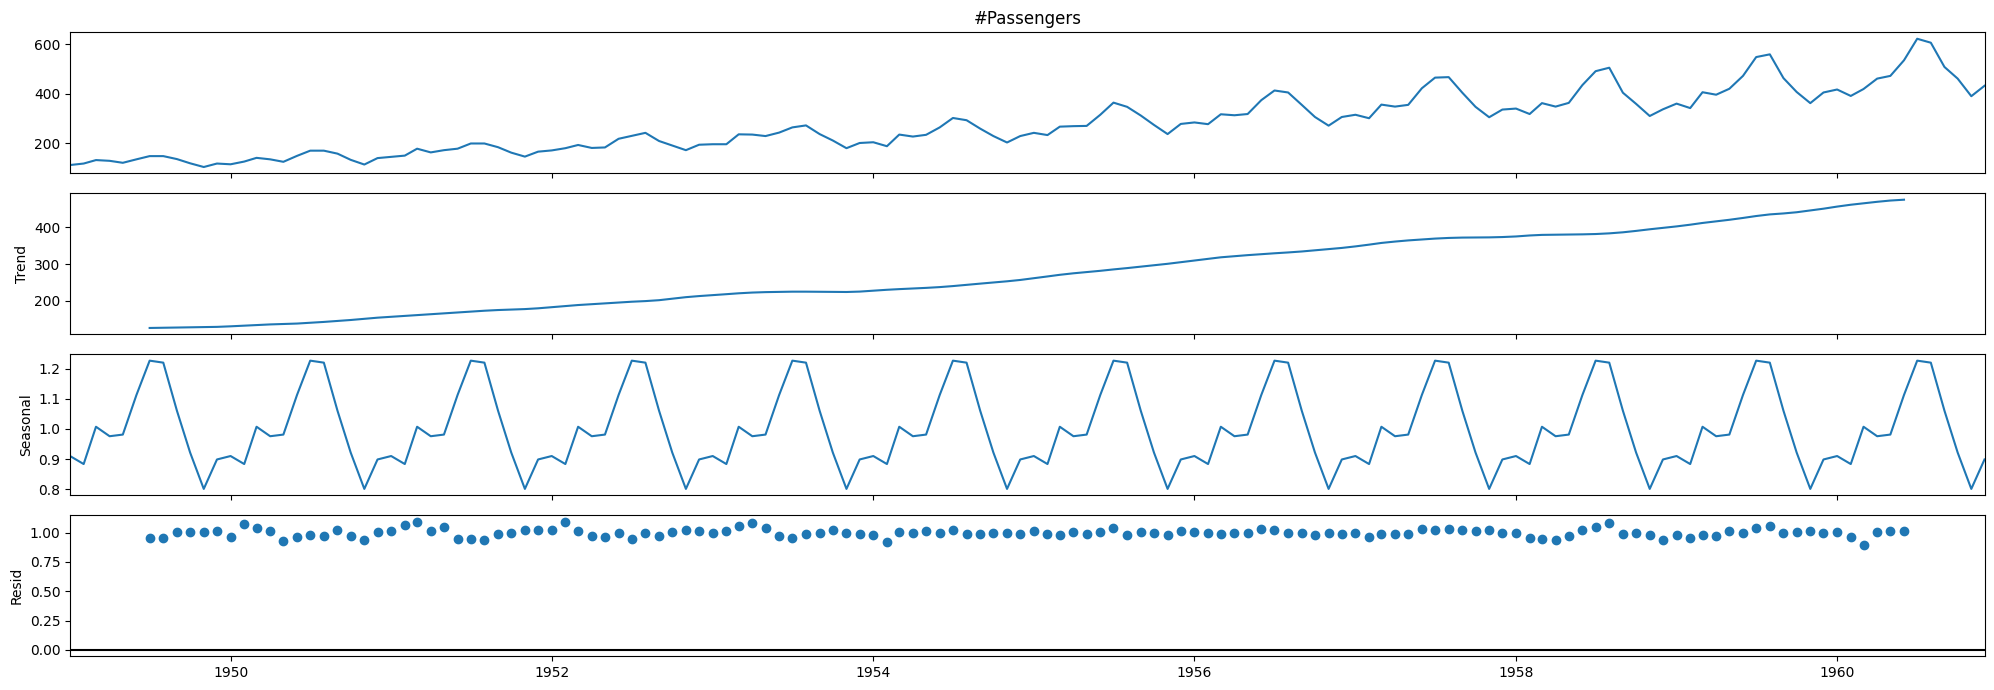

In [17]:
components = seasonal_decompose(df['#Passengers'], model='multiplicative')
components.plot()

The plot above clearley shows the increasing trend in passengers amount as well 12 months seasonality
Residual plot or noise shows that there is no correlation in data.


### Removing trend by differencing

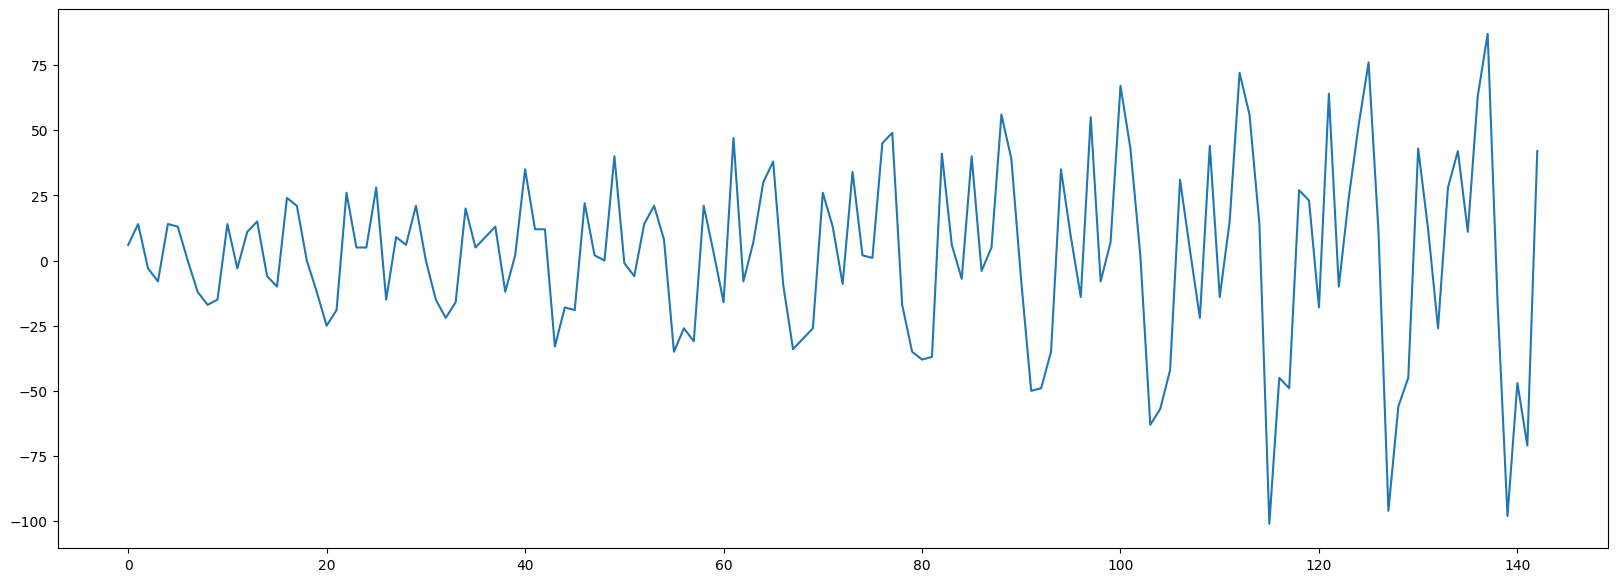

In [18]:
X = df.values
diff = list()
for i in range (1, len(X)):
    value = X[i] - X[i-1]   #difference between the original observation and the observation at the previous time step
    diff.append(value)

plt.plot(diff)
plt.show()

The plot above shows detrended data.

<Axes: xlabel='Month'>

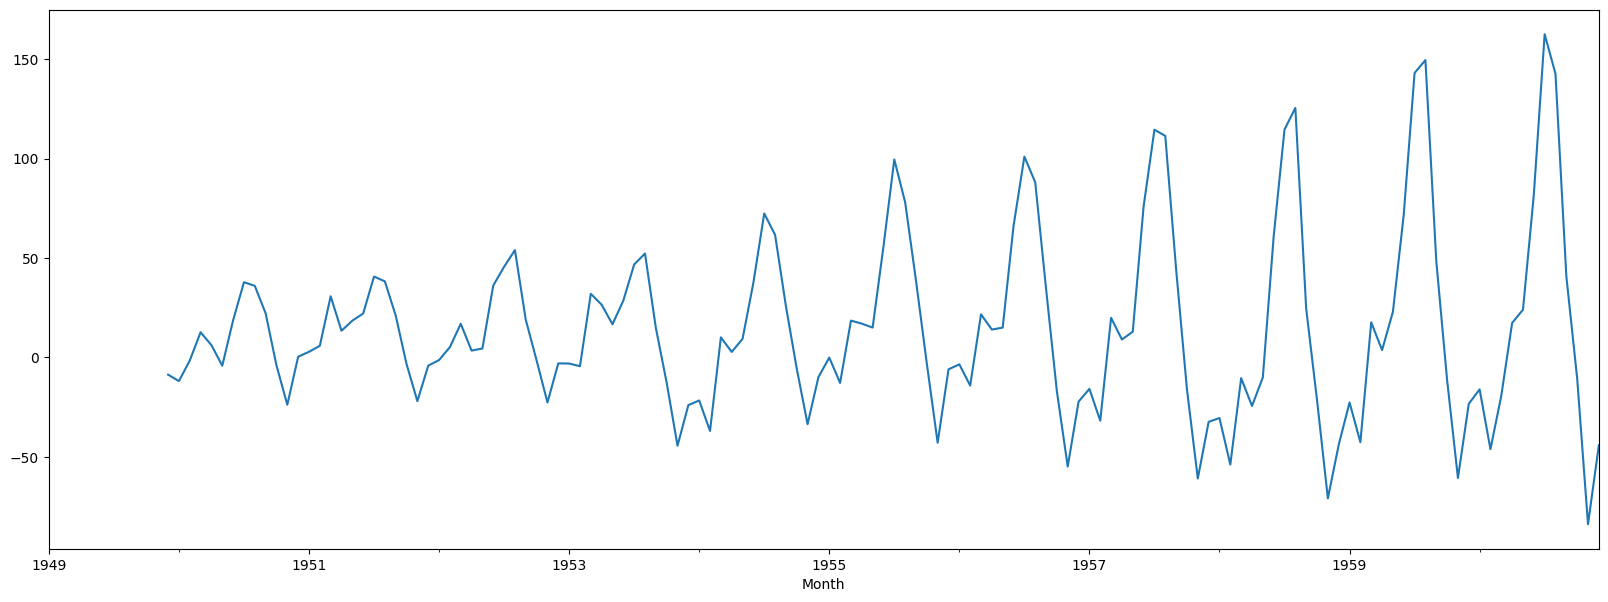

In [33]:
data = df['#Passengers']

rolling_mean = data.rolling(window=12).mean()
data_no_trend= data - rolling_mean
data_no_trend.plot()

## Seasonal Adjustment or Deseasonalizing

<Axes: xlabel='Month'>

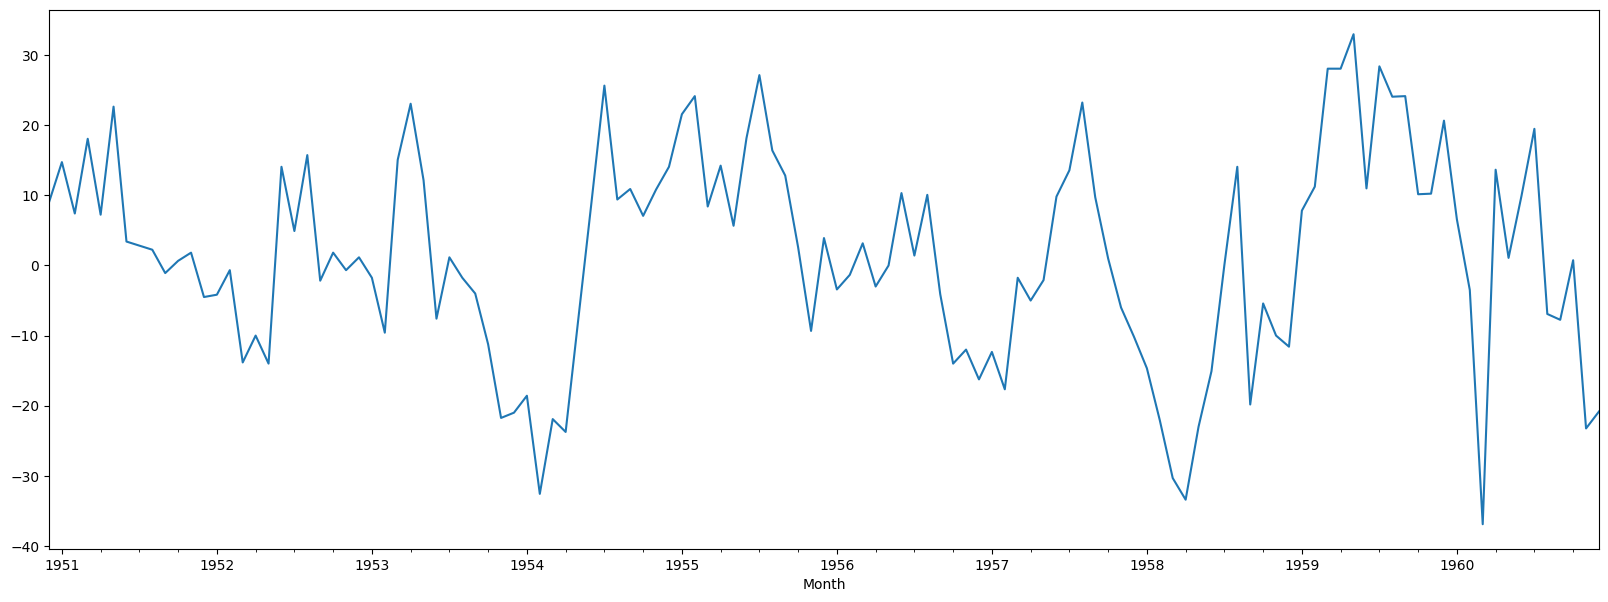

In [20]:
seas_adjusted = data_no_trend.diff(periods=12)
seas_adjusted = seas_adjusted[seas_adjusted.notnull()]
seas_adjusted.plot()

<Axes: xlabel='Month'>

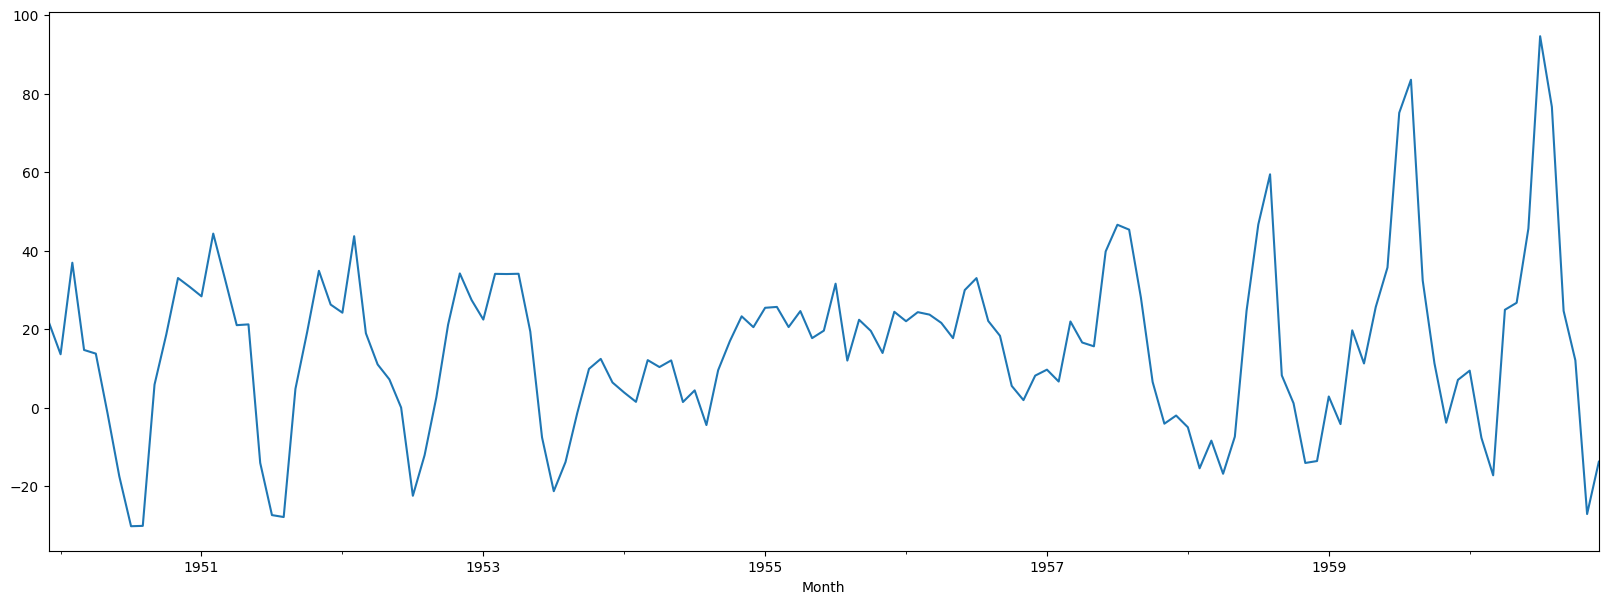

In [21]:
data = data_no_trend[data_no_trend.notnull()]

result = seasonal_decompose(data, model='additive', period=12)
deseasonalized_data = data - result.seasonal
deseasonalized_data.plot()

Both plots above show deseasonalized data

## Auto Regressive Integrated Moving Average (ARIMA)

In [39]:
model = ARIMA(df.values, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Fri, 21 Jul 2023   AIC                           1394.683
Time:                        22:29:47   BIC                           1403.571
Sample:                             0   HQIC                          1398.294
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.0

In [40]:
model = auto_arima(seas_adjusted, trace=True,suppress_warnings=True)
output = model.fit(seas_adjusted)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=933.009, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=999.334, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=933.048, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=961.190, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=998.418, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=931.082, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=938.997, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=932.906, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=932.937, Time=0.24 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=932.005, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=934.892, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=929.228, Time=0.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=937.368, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=931.011, 

In [43]:
model = auto_arima(df, trace=True, suppress_warnings=True)
output_df = model.fit(df)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1415.278, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1403.473, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1398.827, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1413.909, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1396.121, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1398.386, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1397.975, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1394.683, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1397.258, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1401.852, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1378.338, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1396.5

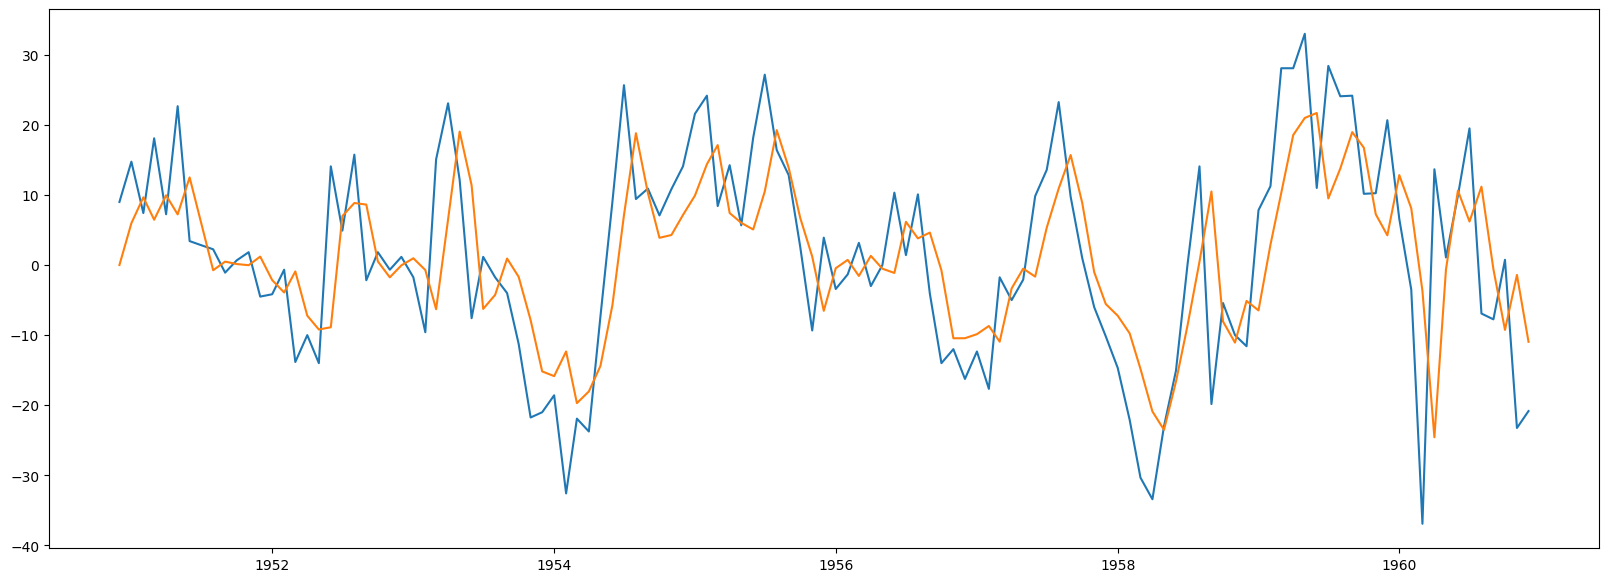

In [41]:
plt.plot(seas_adjusted)
plt.plot(output.fittedvalues())

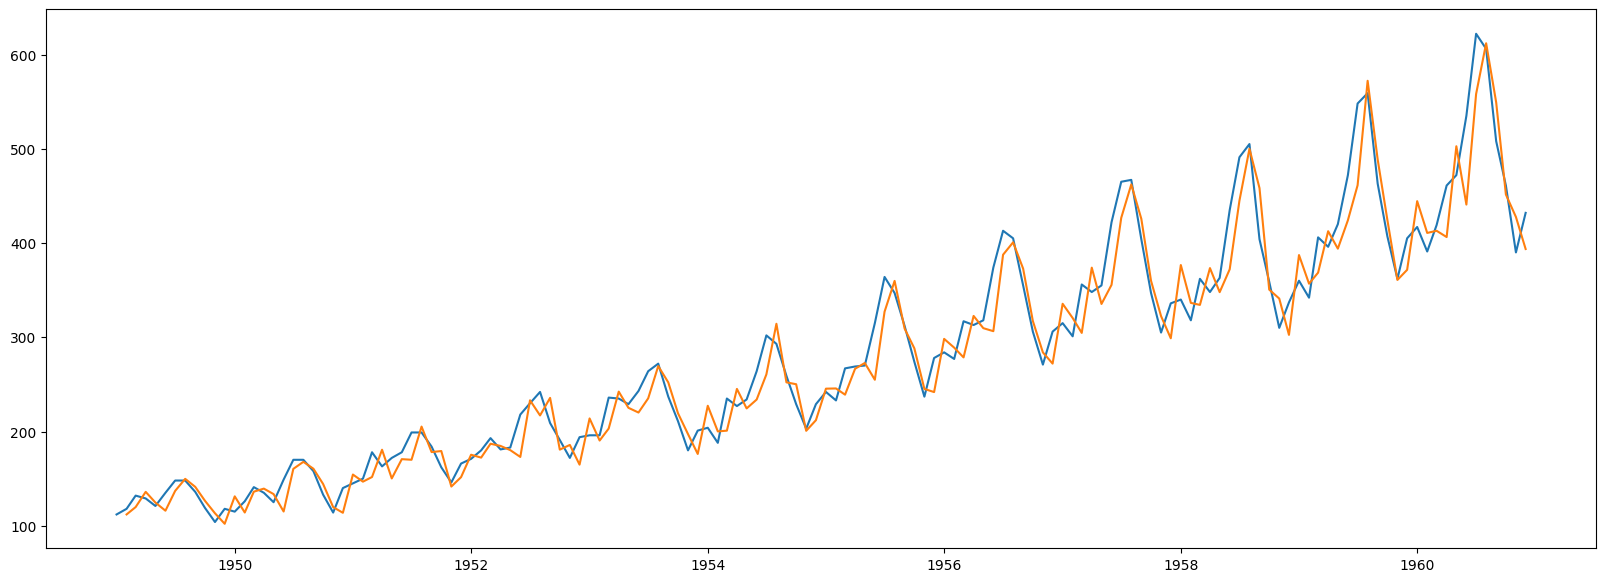

In [44]:
plt.plot(df)
fitted_vals = output_df.fittedvalues()
fitted_vals = fitted_vals[1:]
plt.plot(fitted_vals)